In [2]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram
from constants import MASS_BINS
from mass_function import get_weighted_mass_histogram_cluster_galaxies

In [3]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey (this is the main one)
galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters EFEDS

print('number of galaxies: ', len(sciencegkv_galaxies_raw))
print('number of galaxies: ', len(galaxies_raw))
print('number of the clusters: ', len(clusters_raw))

number of galaxies:  2232985
number of galaxies:  370116
number of the clusters:  542


In [4]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < 1.304) &
    # (sciencegkv_galaxies_raw['Z'] <= 0.4) &
    # (sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (sciencegkv_galaxies_raw['Z'] != 0) &
    # (sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    (sciencegkv_galaxies_raw['RAcen'] > 129.0) &
    (sciencegkv_galaxies_raw['RAcen'] < 141.0) &
    (sciencegkv_galaxies_raw['Deccen'] > -2.0) &
    (sciencegkv_galaxies_raw['Deccen'] < 3.0)  &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        # (galaxies_raw['Z'] <= 0.4) &
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < 1.304) &
        (galaxies_raw['RAcen'] > 129.0) &
        (galaxies_raw['RAcen'] < 141.0) &
        (galaxies_raw['Deccen'] > -2.0) &
        (galaxies_raw['Deccen'] < 3.0)  &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP']) &  # mask clusters which don't have VDISP values
        (clusters_raw['ZBEST'] <= 1.304) &
        (clusters_raw['RA'] > 128.5007) &
        (clusters_raw['RA'] < 141.5) &
        (clusters_raw['DEC'] > -2.05) &
        (clusters_raw['DEC'] < 3.02)
)



big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]
print('number of the galaxies in big survey after masking:   ', len(big_galaxy_catalog))
print('number of the galaxies in small survey after masking: ', len(galaxy_catalog))
print('number of the clusters after masking:                 ', len(cluster_catalog))


number of the galaxies in big survey after masking:    49986
number of the galaxies in small survey after masking:  48322
number of the clusters after masking:                  162


In [48]:
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

/media/farnoosh/LMU/nextcloud/jupyternotebooks/erosita_DR1/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [6]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['ZBEST'].byteswap().newbyteorder(),
    'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),
    # 'Cluster_MASS'
    'VDISP_error': cluster_catalog['VDISP_ERR'].byteswap().newbyteorder()
})



# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder()
})

print(galaxy_df)

                uberID          RA       DEC        z         mstar
0      138021052006945  137.992346  2.570577  0.21327  3.294812e+10
1      131010293406270  131.307189  1.507075  0.20730  1.506049e+10
2      136000563202354  136.053008  0.138277  0.27538  5.989433e+10
3      130020205007803  130.790764  2.651356  0.29370  9.169161e+10
4      130990151906125  131.440319 -0.506608  0.15497  4.314327e+10
...                ...         ...       ...      ...           ...
48317  130990634008739  130.986376 -0.260436  0.26954  2.591990e+10
48318  135021016609990  135.025604  2.857325  0.19924  3.190467e+10
48319  135000832810514  134.799377  0.906732  0.02531  9.149594e+07
48320  140000362709494  140.241766  0.810503  0.02381  1.054762e+08
48321  137021074202062  136.971637  2.110832  0.27823  6.388143e+10

[48322 rows x 5 columns]


In [7]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)

print(matched_galaxy_dataframe[matched_galaxy_dataframe['environment'] != 'Field'].head())

Progress: 99.99717546039996%%%%               uberID          RA       DEC        z         mstar  \
88    133990088904009  134.499717 -0.705824  0.24617  1.333348e+11   
3136  133010916710138  132.720042  1.871261  0.26990  9.799654e+10   
3162  133010919010312  132.717570  1.887796  0.26838  3.409750e+11   
3192  133010921210443  132.715813  1.900014  0.26515  3.333256e+10   
3213  133010923910284  132.713116  1.885054  0.26709  1.541602e+11   

        environment cluster_mass           cluster_name  cluster_radius  
88    ClusterMember         None  eFEDSJ085801.1-004103        0.592899  
3136  ClusterMember         None  eFEDSJ085051.8+015331        0.675105  
3162  ClusterMember         None  eFEDSJ085051.8+015331        0.675105  
3192  ClusterMember         None  eFEDSJ085051.8+015331        0.675105  
3213  ClusterMember         None  eFEDSJ085051.8+015331        0.675105  


In [7]:
matched_galaxy_dataframe.to_csv('matched_galaxy_df.csv')

NameError: name 'matched_galaxy_dataframe' is not defined

In [7]:
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [8]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner" , on="uberID")
print(merged_galaxy_df[merged_galaxy_df["environment"] != "Field"])

                uberID  completeness region  Unnamed: 0          RA       DEC  \
88     133990088904009      0.961724    G09          88  134.499717 -0.705824   
3136   133010916710138      0.952396    G09        3136  132.720042  1.871261   
3162   133010919010312      0.964515    G09        3162  132.717570  1.887796   
3192   133010921210443      0.928652    G09        3192  132.715813  1.900014   
3213   133010923910284      0.961645    G09        3213  132.713116  1.885054   
...                ...           ...    ...         ...         ...       ...   
33293  135990538800438      0.911435    G09       33293  136.076038 -1.042156   
34108  131010112805172      0.949085    G09       34108  131.477220  1.403674   
34725  133010596604768      0.959548    G09       34725  133.021470  1.365789   
34924  136991114306938      0.924461    G09       34924  136.534038 -0.430051   
35197  132020164006107      0.930378    G09       35197  132.829446  2.491626   

             z         msta

In [10]:
# get the mass histograms (galaxy mass function) and errors

# get the histogram for all galaxies
mass_histogram_all_galaxies, mass_histogram_all_galaxies_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df, region_name="G09")

# get the histogram for all galaxies in the field
mass_histogram_field_only, mass_histogram_field_only_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "Field"], region_name="G09")
# mass_histogram_field_only, mass_histogram_field_only_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["MASS"] > or < VALUE], region_name="G09")


# get the histogram for all galaxies which are cluster members
mass_histogram_cluster_members, mass_histogram_cluster_members_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"], region_name="G09")
sum_volume_all_cluster = sum(4 / 3 * np.pi * (cluster_df['cluster_radius_Mpc'])**3)

88       0.961724
3136     0.952396
3162     0.964515
3192     0.928652
3213     0.961645
           ...   
33293    0.911435
34108    0.949085
34725    0.959548
34924    0.924461
35197    0.930378
Name: completeness, Length: 295, dtype: float64


<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7899/3405003129.py:36: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_7899/3405003129.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)


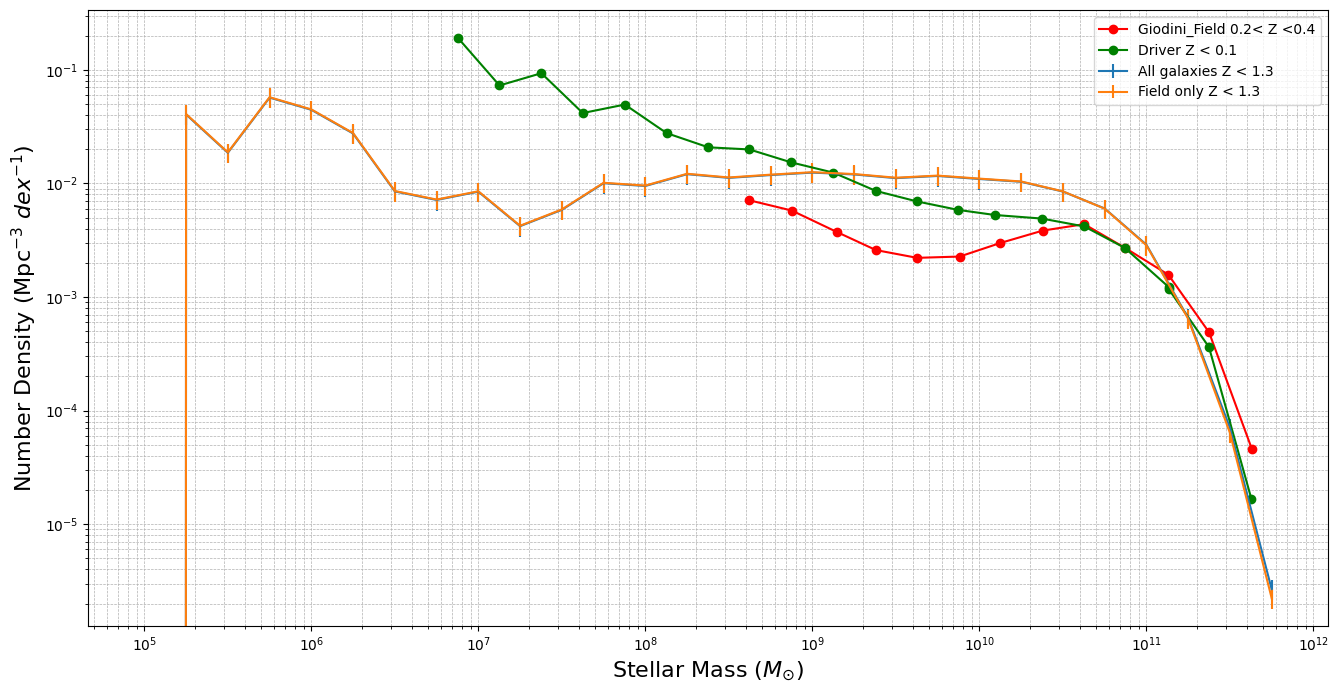

In [56]:
# Load the data from the CSV file
giodini_field4_02_to_04 = '/home/farnoosh/Desktop/thesis/giodini_fig4_field_passive_02_04.csv'
driver_fig12_z_less_than_01 = '/home/farnoosh/Desktop/thesis/driver_fig12_z_less_than0.1.csv'

giodini_field_02_to_04 = pd.read_csv(giodini_field4_02_to_04, header=None, names=['x', 'y'])
driver_fig12_01 = pd.read_csv(driver_fig12_z_less_than_01, header=None, names=['x', 'y'])

# Sort the driver data by the x-values
driver_fig12_01 = driver_fig12_01.sort_values(by='x')

fig, ax = plt.subplots(figsize=(16, 8))

ratio_of_field_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "Field"]) / len(merged_galaxy_df)
ratio_of_cluster_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"]) / len(merged_galaxy_df)

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_all_galaxies,
    yerr=mass_histogram_all_galaxies_errors,
    label='All galaxies Z < 1.3',
)

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_field_only / ratio_of_field_galaxies,
    yerr=mass_histogram_field_only_errors / ratio_of_field_galaxies,
    label='Field only Z < 1.3',
)

# Add the new data from the CSV file
plt.plot(10**giodini_field_02_to_04['x'], giodini_field_02_to_04['y'] / (0.7**3), marker='o', color='red', linestyle='-', label='Giodini_Field 0.2< Z <0.4')
plt.plot(driver_fig12_01['x'], driver_fig12_01['y'], marker='o', color='green', linestyle='-', label='Driver Z < 0.1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
# plt.xlim((10**9.5, 10**12))
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7899/2575573307.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_7899/2575573307.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)


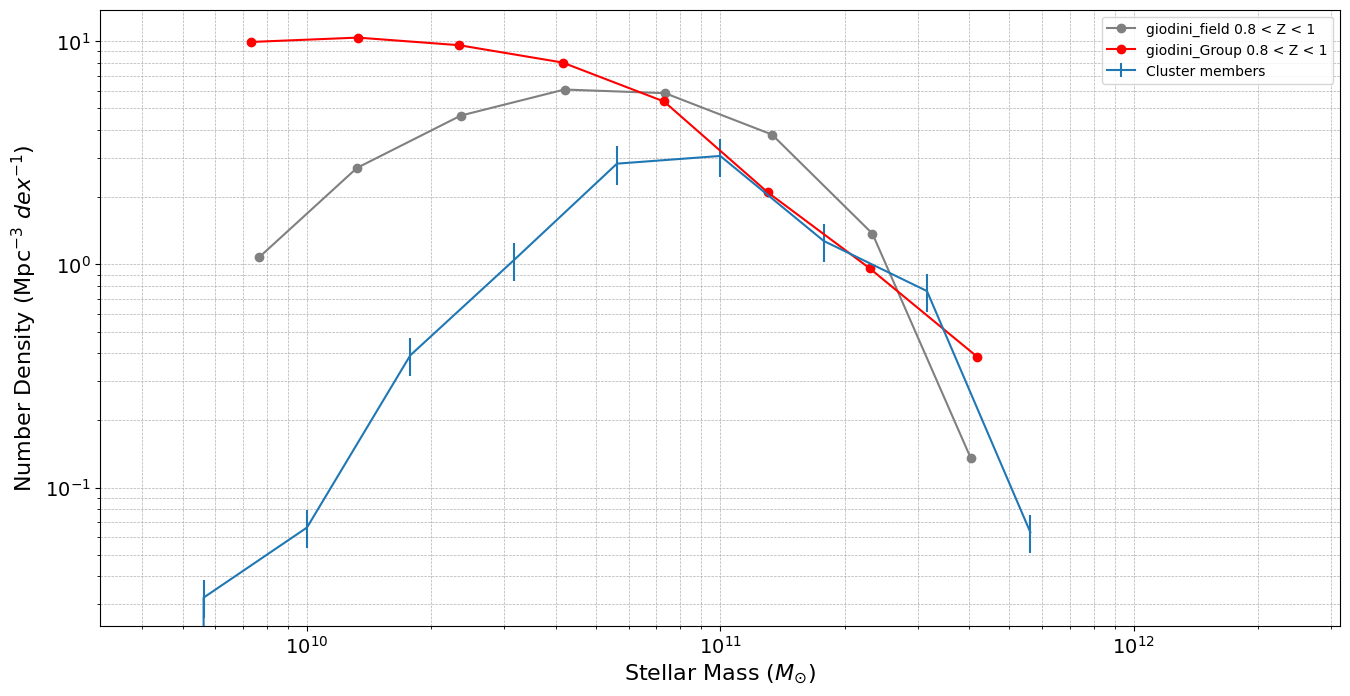

In [54]:
giodini_fig_9_field_08_1 = '/home/farnoosh/Desktop/thesis/giodini_gif9_low_mass_08_1.csv'
giodini_field_08_1 = pd.read_csv(giodini_fig_9_field_08_1, header=None, names=['x', 'y'])

giodini_fig4_HGroup_08_1 = '/home/farnoosh/Desktop/thesis/giodini_fig4_High_mass_Group_08_1.csv'
giodini_HGroup_08_1 = pd.read_csv(giodini_fig4_HGroup_08_1, header=None, names=['x', 'y'])


fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_cluster_members / sum_volume_all_cluster,
    yerr=mass_histogram_cluster_members_error / sum_volume_all_cluster,
    label='Cluster members',
)

plt.plot(10**giodini_field_08_1['x'], giodini_field_08_1['y'], marker='o', color='gray', linestyle='-', label='giodini_field 0.8 < Z < 1')
plt.plot(10**giodini_HGroup_08_1['x'], giodini_HGroup_08_1['y'], marker='o', color='red', linestyle='-', label='giodini_Group 0.8 < Z < 1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
plt.xlim((10**9.5, 10**12.5))
# plt.ylim((10**-5.7, 10**2.5))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [99]:

# Find the clusters that have galaxies among them
unique_cluster_ids = matched_galaxy_dataframe['cluster_name'].unique()

# Print the clusters and their galaxies
cluster_galaxies = matched_galaxy_dataframe.groupby('cluster_name')['uberID'].apply(list).reset_index()
cluster_galaxies['num_galaxies'] = cluster_galaxies['uberID'].apply(len)

# Print the clusters with galaxies
for index, row in cluster_galaxies.iterrows():
    print(f"Cluster {row['cluster_name']} has the following {len(row['uberID'])} galaxies within: {row['uberID']}")

Cluster eFEDSJ083723.6+012413 has the following 2 galaxies within: [129010249405188, 129010251405245]
Cluster eFEDSJ083857.5+020846 has the following 1 galaxies within: [129020288502277]
Cluster eFEDSJ083859.3+022841 has the following 3 galaxies within: [129020239905865, 129020250506017, 129020265906139]
Cluster eFEDSJ083921.0-014149 has the following 2 galaxies within: [129980806004077, 129980843803897]
Cluster eFEDSJ083930.3-014348 has the following 1 galaxies within: [129980700203693]
Cluster eFEDSJ083933.8-014044 has the following 10 galaxies within: [129980691504042, 129980718704484, 129980726504382, 129980734604223, 129980737204294, 129980742104166, 129980747104443, 129980747104360, 129980750004315, 129980751304575]
Cluster eFEDSJ084000.0-013109 has the following 12 galaxies within: [129980579306061, 129980582405863, 129980584405561, 129980592905913, 129980595905559, 129980615705766, 129980619005510, 129980620905931, 129980623405621, 129980636605566, 129980638105902, 129980658805

In [100]:
# Find the maximum number of galaxies in a cluster
max_galaxies_row = cluster_galaxies.loc[cluster_galaxies['num_galaxies'].idxmax()]
print(f"Cluster {max_galaxies_row['cluster_name']} has the maximum number of galaxies: {max_galaxies_row['num_galaxies']}")

# Count the number of clusters with only one galaxy within them
clusters_with_one_galaxy = sum(cluster_galaxies['num_galaxies'] == 1)
print(f"Number of clusters with only one galaxy: {clusters_with_one_galaxy}")

Cluster eFEDSJ091610.1-002348 has the maximum number of galaxies: 23
Number of clusters with only one galaxy: 5


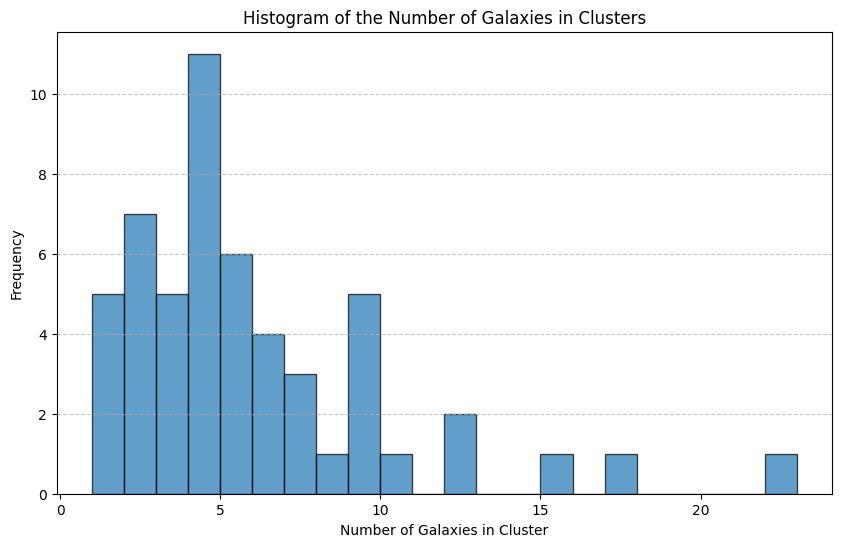

In [101]:
plt.figure(figsize=(10, 6))
plt.hist(cluster_galaxies['num_galaxies'], bins=range(1, cluster_galaxies['num_galaxies'].max() + 1), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Galaxies in Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Galaxies in Clusters')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [102]:
# Calculate the total number of galaxies within clusters
total_galaxies = cluster_galaxies['num_galaxies'].sum()
print(f"Total number of galaxies within clusters: {total_galaxies}")

Total number of galaxies within clusters: 295


In [103]:
# Find clusters with no galaxies
all_cluster_names = cluster_df['c_NAME'].unique()
clusters_with_galaxies = matched_galaxy_dataframe['cluster_name'].dropna().unique()
clusters_without_galaxies = np.setdiff1d(all_cluster_names, clusters_with_galaxies)

print('number of clusters with galaxies among them:', len(clusters_with_galaxies))
print("number of clusters with no galaxies within: ", len(clusters_without_galaxies))
# for cluster_name in clusters_without_galaxies:
#     print(f"Cluster name without a galaxy: {cluster_name}")

number of clusters with galaxies among them: 53
number of clusters with no galaxies within:  109
